# Bunch rotation

- Currently, bunch rotation is performed in the SPS by using the main h=4620 system (~200MHz)
- We will start by reproducing this manipulation in a simple single-particle tracker: henontrack (designed by me... Not really a professional tool)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import henontrack.utils as hutils
import henontrack.objects as hobjects
import henontrack.hamilton as hamil

from copy import deepcopy
from pprint import pprint
from henontrack.slow_extractions import SlowExtraction

In [2]:
# Basic machine and beam params

beam_dict, machine_dict = deepcopy(hutils.beams['sps']), deepcopy(hutils.machines['sps'])
pprint(beam_dict)
pprint(machine_dict)

{'dpp_0': 0.0015, 'dpp_half': 0.0015, 'emit_nx': 8e-06, 'particle': 'proton'}
{'beta_septum': 81,
 'dq1': -26.67,
 'energy': 400.001,
 'flattop': 4.8,
 'gammatr': 23.26,
 'harmonic': 4620,
 'length': 6911.5038,
 'max_GV': 0.007,
 'q1': 26.666666666666668,
 'sext_str': 169.3,
 'x_septum': 0.02}


In [3]:
# Basic bunch rotation params

steps_to_stationary = 300
steps_unstable = int(0.95/23e-3) # From SFTPRO1
steps_rotate = int((2.45-0.6)/23e-3) # From SFTPRO1
steps_debunch = 100
gv_200 = 7.5e-3
v_pct_800 = 0.
phi_800 = -np.pi/2

steps = steps_to_stationary + steps_unstable + steps_rotate + steps_debunch

In [4]:
# Generate RF waveform coefficients for these parameters:

fouriers = []

for step in range(steps):
    if (step < steps_to_stationary):
        v_knob = 1
        v_sign = 1
    elif (step < steps_to_stationary+steps_unstable):
        v_knob = 1
        v_sign = -1
    elif (step < steps_to_stationary+steps_unstable+steps_rotate):
        v_knob = 1
        v_sign = 1
    else:
        v_knob = 0
        v_sign = 1
        
    fourier_tmp = hamil.Fourier(a=[0, 0, 0, 0, v_knob*gv_200*v_pct_800*np.cos(phi_800)],
                                b=[0, v_sign*v_knob*gv_200, 0, 0, v_knob*gv_200*v_pct_800*np.sin(phi_800)])
    fouriers.append(fourier_tmp)

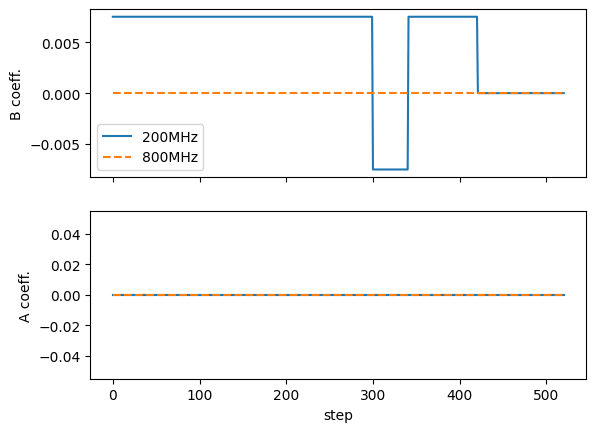

In [5]:
f, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot([f_.b[1] for f_ in fouriers], label='200MHz')
ax[0].plot([f_.b[4] for f_ in fouriers], label='800MHz', ls='--')
ax[1].plot([f_.a[1] for f_ in fouriers])
ax[1].plot([f_.a[4] for f_ in fouriers], ls='--')
ax[0].set_ylabel('B coeff.')
ax[1].set_ylabel('A coeff.')
ax[1].set_xlabel('step')
ax[0].legend()

In [10]:
# Construct lattice and tracking job

sx = SlowExtraction(beam_dict=beam_dict, machine_dict=machine_dict)
sx.add_rf = False  # We will add it "by hand below" with our custom coeffs.
sx.n_particles = 10000
sx.add_sext = False  # Only for transverse simulation
sx.add_quad = False  # Only for transverse simulation
sx.add_bpm = True  # Beam position monitor -> stores beam state as function of time
sx.bpm_broadcast_step = 20  # store every 20 steps
sx.n_buckets = 1  # Number of buckets to populate with beam
sx.match_to_bucket = True  # Create distribution that matches bucket shape
sx.bucket_fraction_rms = 0.02  # Fraction of bucket occupied by beam root mean squared area
sx.t_harmonic = 4620
sx.mom_dist = 'Gauss'
sx.t_dist = 'Gauss'
sx.steps = steps

sx.create_cycle()
sx.create_lattice()
sx.create_septum()
voltage = hamil.FVoltage(fouriers, sx.cycle, harmonic=sx.harmonic)
sx.lattice.append(voltage)
sx.create_beam()
beam_df_initial = sx.beam.dframe()

Gamma: 426.44029850746267
Beta: 0.9999972504974676
Emittance: 1.876000468079763e-08


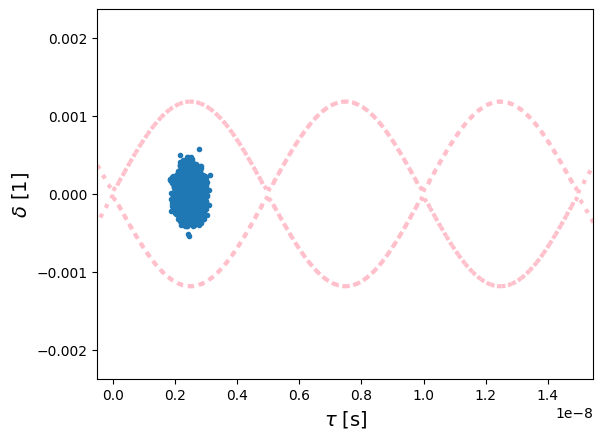

In [11]:
# The sx object has as attribute a hamiltonian object to do some semi-analytical calculations...
# e.g. it can compute the bucket separatrices

f, axis = plt.subplots()
plt_dict = sx.hamiltonian.plot_longitudinal_dpp(step=0, minimal=True, ax=axis, fill=False, periods_min=0, periods_max=3)

xs = beam_df_initial.t
ys = beam_df_initial.dpp
plt_dict['ax'].scatter(xs, ys, marker='.')

In [12]:
# This cell runs the physics model in time
sx.extract()

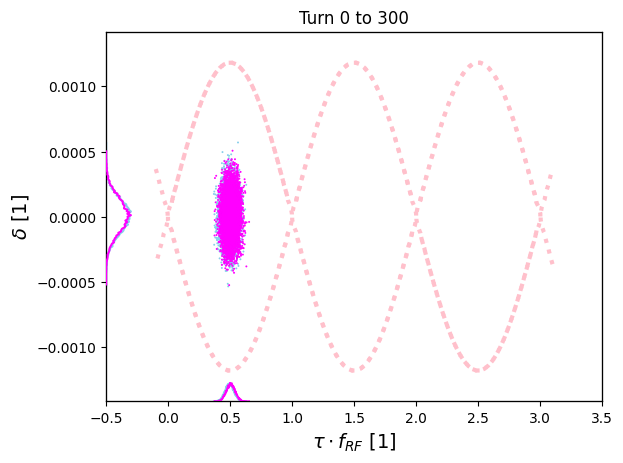

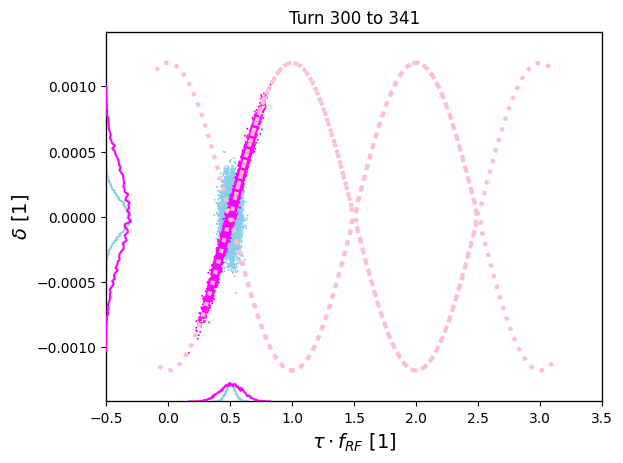

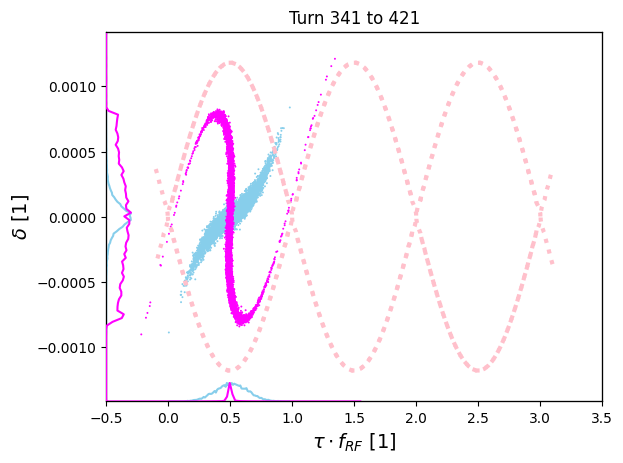

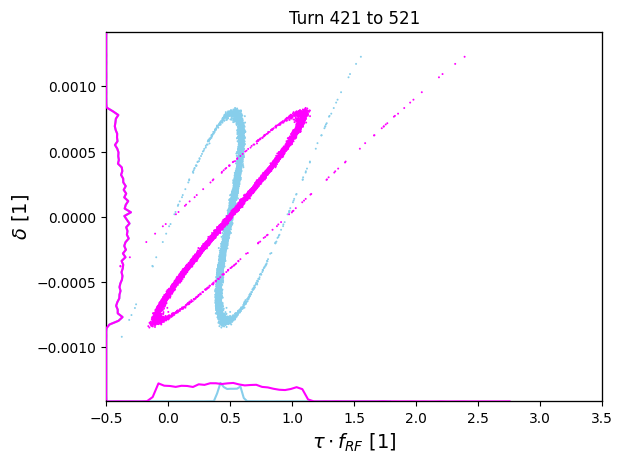

In [13]:
# We can now plot all the stages of the manipulation

bpm = sx.lattice_dict['BPM2']
bpm_df = bpm.dframe()

lower_limits = [0,
                steps_to_stationary,
                steps_to_stationary+steps_unstable,
                steps_to_stationary+steps_unstable+steps_rotate,
               ]

upper_limits = lower_limits[1:] + [sx.cycle.end_step]
f_rf = sx.hamiltonian.voltage.f[0]
dpp_max = sx.hamiltonian.dpp_bucket_height(step=1)

for lower, upper in zip(lower_limits, upper_limits):
    f, axis = plt.subplots()
    
    bpm_tmp = bpm_df[(bpm_df.turn>=lower)&(bpm_df.turn<upper)]
    bpm_tmp_initial = bpm_tmp[bpm_tmp.turn==bpm_tmp.turn.min()]
    bpm_tmp_final = bpm_tmp[bpm_tmp.turn==bpm_tmp.turn.max()]
    
    axis.scatter(bpm_tmp_initial.t*f_rf, bpm_tmp_initial.dpp, color='skyblue', s=2, edgecolor='none')
    axis.scatter(bpm_tmp_final.t*f_rf, bpm_tmp_final.dpp, color='fuchsia', s=2, edgecolor='none')

    f_dict = hutils.plot_kernels(bpm_tmp_initial.t*f_rf, bpm_tmp_initial.dpp, x=bpm_tmp_initial.t*f_rf, y=bpm_tmp_initial.dpp,
                      kde_kwargs={'c': 'skyblue'}, ax=axis, hist=True)
    hutils.plot_kernels(bpm_tmp_final.t*f_rf, bpm_tmp_final.dpp, x=bpm_tmp_final.t*f_rf, y=bpm_tmp_final.dpp, ax=axis,
                      hist=True, kde_kwargs={'c': 'fuchsia'})
    sx.hamiltonian.plot_longitudinal_dpp(step=lower, minimal=True, ax=axis, fill=False, periods_min=0, periods_max=3, norm_x=1/f_rf)
    
    f_dict['ax'].set_ylabel(r'$\delta$ [1]')
    f_dict['ax'].set_xlabel(r'$\tau \cdot f_{RF}$ [1]')
    axis.set_ylim(-1.2*dpp_max, 1.2*dpp_max)
    axis.set_xlim(-0.5, 3.5)
    axis.set_title('Turn {} to {}'.format(lower, upper))


In [14]:
# Compute some relevant observables of the final distribution

bpm_final = bpm_df[(bpm_df.turn == bpm_df.turn.max())]

Text(0.5, 1.0, 'KL Divergence: 0.0525')

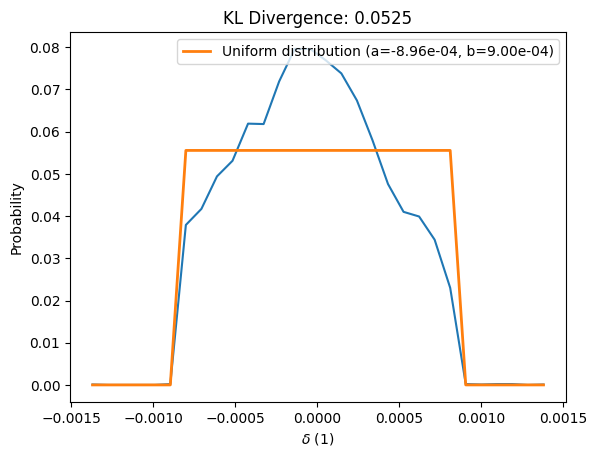

In [51]:
# Find the "closest" uniform distribution for dpp -> the one that minimises KL divergence
# Ideal distribution: as wide as possible -> maximise (b-a) + as uniform as possible -> minimise KL

from scipy.stats import entropy
from scipy.optimize import minimize
from functools import partial

data = bpm_final.dpp.values
# Create histogram
counts, bin_edges = np.histogram(data, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
counts += 1e-5  # Avoid dividing by zero
probability_counts = counts / np.sum(counts)

# Define the objective function for optimization
def kl_divergence_uniform(params, debug=False):
    a, b = params
    if a >= b:  # To ensure a < b
        return np.inf
    uniform_pdf = np.zeros_like(bin_centers)
    in_range = (bin_centers >= a) & (bin_centers <= b)
    uniform_pdf[in_range] = 1.0 / (b - a)
    uniform_pdf += 1e-5 
    uniform_pdf = uniform_pdf / np.sum(uniform_pdf)  # Normalize the uniform distribution
    cost = entropy(uniform_pdf, probability_counts)
    if debug:
        f, ax =  plt.subplots()
        ax.plot(bin_centers, probability_counts)
        ax.plot(bin_centers, uniform_pdf)
        ax.set_title(f'{a}, {b}: {cost}')
    return cost

# Initial guess for a and b
initial_guess = [np.min(data)*0.5, np.max(data)*0.5]

# Perform the optimization
result = minimize(partial(kl_divergence_uniform, debug=False),
                  initial_guess, bounds=[(np.min(data), np.mean(data)), (np.mean(data), np.max(data))])

# Get the optimized a and b
a_opt, b_opt = result.x

# Calculate the uniform distribution with optimized a and b
uniform_pdf_opt = np.zeros_like(bin_centers)
in_range_opt = (bin_centers >= a_opt) & (bin_centers <= b_opt)
uniform_pdf_opt[in_range_opt] = 1.0 / (b_opt - a_opt)
uniform_pdf_opt = uniform_pdf_opt / np.sum(uniform_pdf_opt)  # Normalize the uniform distribution

# Calculate the KL divergence with optimized a and b
kl_divergence_opt = kl_divergence_uniform([a_opt, b_opt])

# Plot the histogram and the optimized uniform distribution
plt.plot(bin_centers, probability_counts)
plt.plot(bin_centers, uniform_pdf_opt, label=f'Uniform distribution (a={a_opt:.2e}, b={b_opt:.2e})', linewidth=2)
plt.ylabel('Probability')
plt.xlabel(r'$\delta$ (1)')
plt.legend()
plt.title(f'KL Divergence: {kl_divergence_opt:.4f}')

Text(0, 0.5, 'Bunch length (s)')

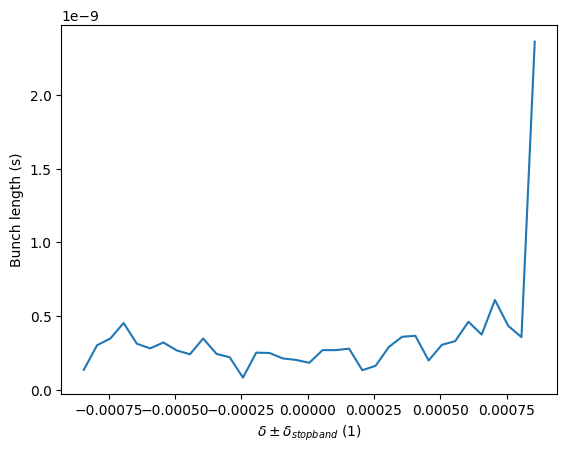

In [57]:
# Compute the bunch length within thin momentum slices
# The relevant width of the slice comes from the slow extraction process (can explain further)
# Ideal distribution: to be discussed

mom_slice = 5e-5
window_limits = np.arange(bpm_final.dpp.min(), bpm_final.dpp.max(), mom_slice)
lowers_dpp = window_limits[:-1]
uppers_dpp = window_limits[1:]
mids_dpp = 0.5*(lowers_dpp + uppers_dpp)

stdevs_t = []

for lower_dpp, upper_dpp in zip(lowers_dpp, uppers_dpp):
    df_slice = bpm_final[(bpm_final.dpp >= lower_dpp) & (bpm_final.dpp <= upper_dpp)]
    stdevs_t.append(df_slice.t.std())
    
f, ax = plt.subplots()
ax.plot(mids_dpp, stdevs_t)
ax.set_xlabel(r'$\delta \pm \delta_{stopband}$ (1)')
ax.set_ylabel(r'Bunch length (s)')